# LeNet5를 구현해보자!


- 아래 그림처럼 CNN 구조를 구축해서 LeNet5를 구현하려 \합니다.

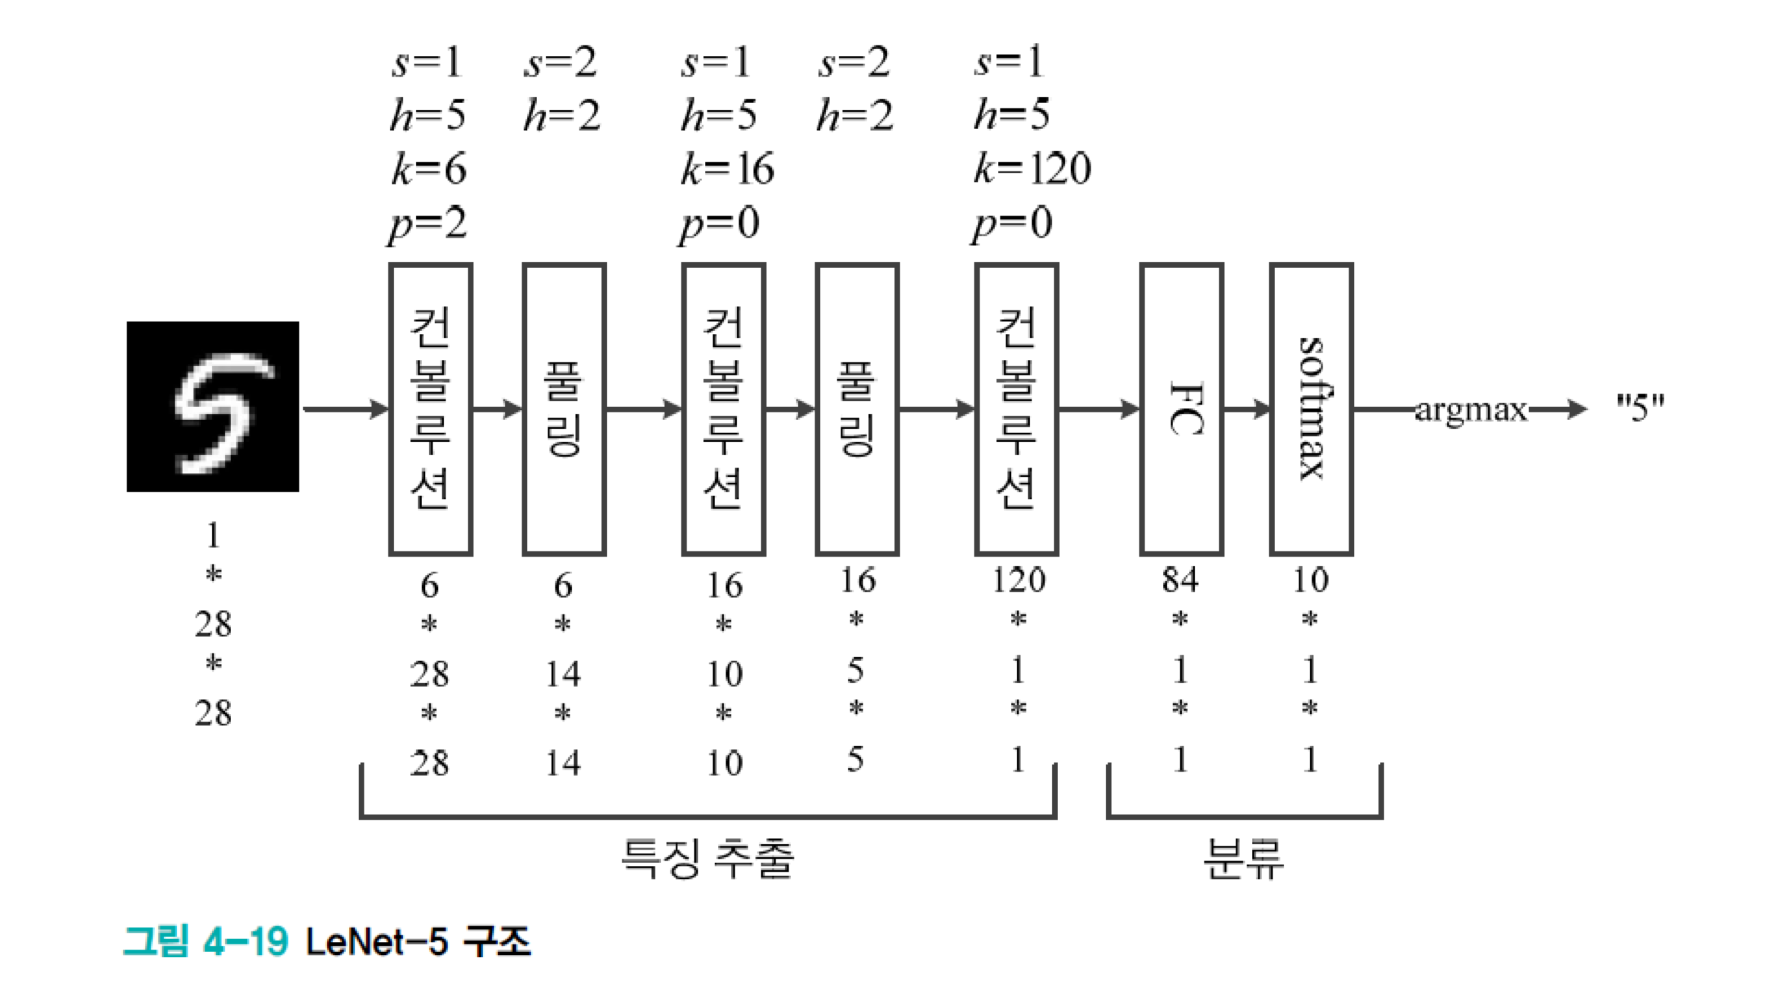

## data

- MNIST 데이터 셋을 활용하였습니다.
- 데이터 이미지와 정답(target)을 출력하여 확인하도록 했습니다.

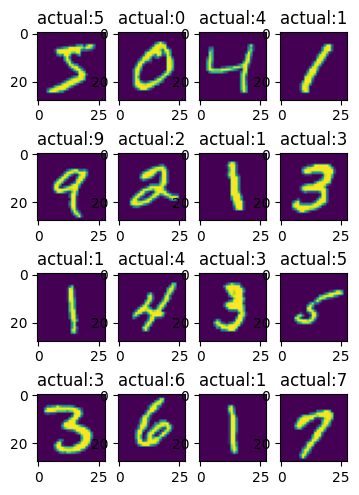

In [ ]:
import matplotlib.pyplot as plt

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

#train
training_data = MNIST(root='./data',train= True, download = True, transform = ToTensor())
#test
test_data = MNIST(root='./data',train= False ,download = True ,transform = ToTensor())

plt.figure(figsize=(4,6))
for i in range(16):
   plt.subplot(4, 4, i+1)
   plt.imshow(training_data.data[i]) #이미지 출력을 위한 부분
   plt.title(f'actual:{training_data.targets[i]}')
plt.show()

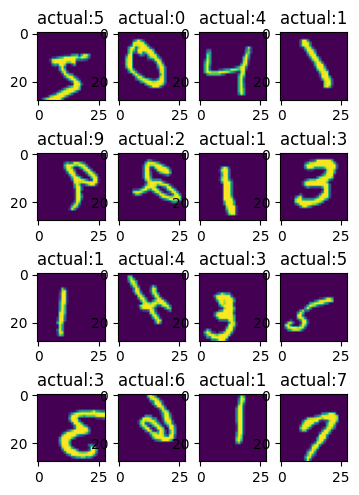

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomCrop
import torchvision.transforms as T #이미지 자유자재 변환

cut_img = Compose([T.ToPILImage(),RandomCrop((28,28), padding = 4), RandomHorizontalFlip(p=0.5),])

train_data = MNIST(root='./data', train=True, download=True, transform = cut_img)
test_data = MNIST(root='./data', train=False, download=True, transform = cut_img)

plt.figure(figsize = (4,6))
for i in range(16):
   plt.subplot(4,4, i+1)
   plt.imshow(cut_img(training_data.data[i])) #이미지 출력을 위한 부분
   plt.title(f'actual:{training_data.targets[i]}')
plt.show()

### 데이터 정규화

In [ ]:
import torch
training_data = MNIST(root='./data', train=True, download=True, transform= ToTensor())
imgs = [item[0] for item in training_data]
imgs = torch.stack(imgs,dim=0).numpy()
print(imgs.shape)

mean_c = imgs[:,0,:,:].mean()
print(mean_c)
std_c = imgs[:,0,:,:].std()
print(std_c)

(60000, 1, 28, 28)
0.13066062
0.30810776


- 데이터 정규화 하기

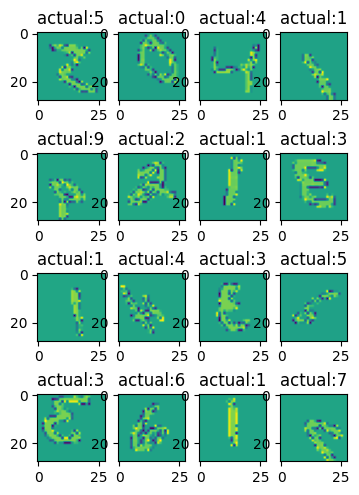

In [ ]:
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomCrop, Normalize

pros_img = Compose([T.ToPILImage(), RandomCrop((28,28), padding = 4), RandomHorizontalFlip(p=0.5), T.ToTensor()
                    ,Normalize(mean = 0.1306, std = 0.3081)
                    ,T.ToPILImage()])

training_data = MNIST(root='./data', train= True, download= True, transform= pros_img)
test_data = MNIST(root='./data', train= False, download= True, transform= pros_img)

plt.figure(figsize = (4,6))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(pros_img(training_data.data[i]))
  plt.title(f'actual:{training_data.targets[i]}')
plt.show() 

##  기본블록 정의

- Conv층을 하나의 블록으로 구성하여 정의하였습니다.
- 활성함수로는 relu함수를 적용하였습니다.
- 성능면에서 maxpooling보다 avgpooling 시 소폭 향상하였기에 이를 적용하였습니다.

In [ ]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module): 
  def __init__(self, in_c, hid_in, hid_out, out_c):
    super(BasicBlock, self).__init__() 

    self.conv1 = nn.Conv2d(in_c, hid_in, kernel_size=5, padding=2)
    self.conv2 = nn.Conv2d(hid_in, hid_out, kernel_size=5, padding=0)
    self.conv3 = nn.Conv2d(hid_out, out_c, kernel_size=5, padding=0)
  
    self.relu = nn.ReLU()  

    #maxpooling -> avgpooling으로 했을 때 (96% -> 98%의 정확도가 나왔다.)
    self.pool = nn.AvgPool2d(kernel_size=2, stride=2) 

  #기본 블록의 순전파
  def forward(self, x): #입력 size : [32,1,28,28]
    x = self.relu(self.conv1(x))
    x = self.pool(x) 
    x = self.relu(self.conv2(x))
    x = self.pool(x)
    x = self.relu(self.conv3(x))
    return x #size([32,120,1,1])

## 모델 정의


- conv이후 분류기에서의 내용에 해당합니다.

In [ ]:
import torch.nn.functional as F
class CNN(nn.Module):
  def __init__(self, class_num):
    super(CNN,self).__init__()
    
    #특징추출 block
    self.block = BasicBlock(1,6,16,120)
    #분류
    self.FC = nn.Linear(in_features = 120, out_features = 84)
    self.out = nn.Linear(in_features=84, out_features= class_num)

    #분류기 활성함수
    self.lsoft = nn.LogSoftmax()

  def forward(self, x): #model 실행될 때 호출
    x = self.block(x) # =self.block.foward(x)
    x = torch.flatten(x, start_dim=1) 

    x = self.FC(x)
    x = self.lsoft(x)
    x = self.out(x)

    return x

## 데이터 로드와 모델 정의

In [ ]:
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

pros_img = Compose([RandomCrop((28,28), padding = 4), RandomHorizontalFlip(p=0.5), T.ToTensor(),Normalize(mean = 0.1306, std = 0.3081)])

#학습, 평가데이터
training_data = MNIST(root='./data', train= True, download= True, transform= pros_img)
test_data = MNIST(root='./data', train= False, download= True, transform= pros_img)
#데이터로더
train_loader = DataLoader(training_data, batch_size=16, shuffle=True) #배치사이즈 조정해보기
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)
#학습 프로세서 선택
device = "cuda" if torch.cuda.is_available() else "cpu"

#CNN 모델 정의
model = CNN(10)

#모델을 device로 보냄
model.to(device)


CNN(
  (block): BasicBlock(
    (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FC): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
  (lsoft): LogSoftmax(dim=None)
)

## 모델 학습

<ipython-input-21-2b856c2d12b4>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.lsoft(x)


epoch1 <Calculation Time:62.1816, Loss:0.0592>
epoch2 <Calculation Time:60.6427, Loss:0.0884>
epoch3 <Calculation Time:61.0537, Loss:0.0085>
epoch4 <Calculation Time:60.2625, Loss:0.0128>
epoch5 <Calculation Time:61.7210, Loss:0.0003>
epoch6 <Calculation Time:61.2451, Loss:0.0893>
epoch7 <Calculation Time:61.2150, Loss:0.0210>
epoch8 <Calculation Time:60.0503, Loss:0.0522>
epoch9 <Calculation Time:61.2973, Loss:0.0297>
epoch10 <Calculation Time:64.3701, Loss:0.0026>


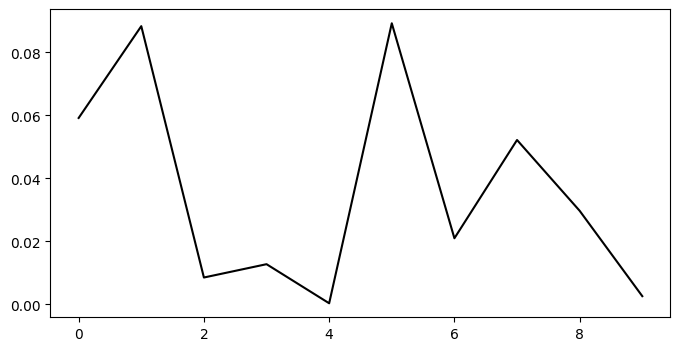

In [ ]:
import time

err_val = []
#학습률 정의 : 1e-3(정확도 96%) -> 1e-4(정확도 98%)
lr = 1e-4

#최적화 기법 정의
#경사하강법 : adam 알고리즘 적용
optim = Adam(model.parameters(), lr=lr)

# 학습 루프 정의
for epoch in range(10):
  start_time = time.time()
  for data, label in train_loader:  # 데이터 호출
       optim.zero_grad()  #기울기 초기화

       preds = model(data.to(device))  # 모델의 예측 : 디바이스로 입력텐서(data)이동

       #오차역전파와 최적화
       loss = nn.CrossEntropyLoss()(preds, label.to(device)) #분류모델에 최적화된 알고리즘 : crossenrtopy손실함수 객체에 (preds, label.to(device))룰 인자로 받는 함수 호출
       loss.backward()#손실함수 그라디언트 계산
       optim.step() #step함수 : 가중치 업데이트 - 모델의 모든 매개변수에 음의 기울기 방향으로 값을 업데이트
 
  cal_time = time.time() - start_time
  # 계산시간 및 손실 출력
  err_val.append(loss.item())
  print("epoch{0} <Calculation Time:{1:.4f}, Loss:{2:.4f}>".format(epoch+1, cal_time, loss.item()))

#cost function 추세 그래프
plt.figure(figsize = (8,4))
plt.plot(err_val,'black', label = 'cost function 추세')
# 모델 저장
torch.save(model.state_dict(), "MNIST.pth")

## 모델 활용

* 라벨의 실제값하고 비교하여 맞는값을 출력하게 하기
  - corr_mask = preds.eq(label.to(device).data) 
      - preds와 label.to(device).data를 비교
      - 잘 맞을 때
        - tensor([9, 0, 1, 7, 8, 9, 8, 9, 2, 6, 1, 3, 5, 4, 8, 2, 6, 4, 3, 4, 5, 9, 2, 0,
        3, 9, 4, 9, 7, 3, 8, 7], device='cuda:0') \<preds>
        - tensor([9, 0, 1, 7, 8, 9, 8, 9, 2, 6, 1, 3, 5, 4, 8, 2, 6, 4, 3, 4, 5, 9, 2, 0,
        3, 9, 4, 9, 7, 3, 8, 7], device='cuda:0')

      - 그 외
        - tensor([2, 1, 8, 3, 9, 6, 1, 7, 2, 4, 4, 5, 7, 0, 2, 1, 6, 6, 8, 2, 7, 7, 2, 4,
        2, 1, 6, 1, 0, 6, 9, 8], device='cuda:0') \<preds>
        - tensor([7, 1, 9, 3, 9, 6, 1, 7, 2, 4, 4, 5, 7, 0, 0, 1, 6, 6, 8, 2, 7, 7, 2, 4,
        2, 1, 6, 1, 0, 6, 9, 8], device='cuda:0')

  - corr_mask출력과 corr_mask.sum()
    - tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True], device='cuda:0')
    - tensor(30, device='cuda:0')

<ipython-input-21-2b856c2d12b4>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.lsoft(x)


Accuracy:98.44000000000001


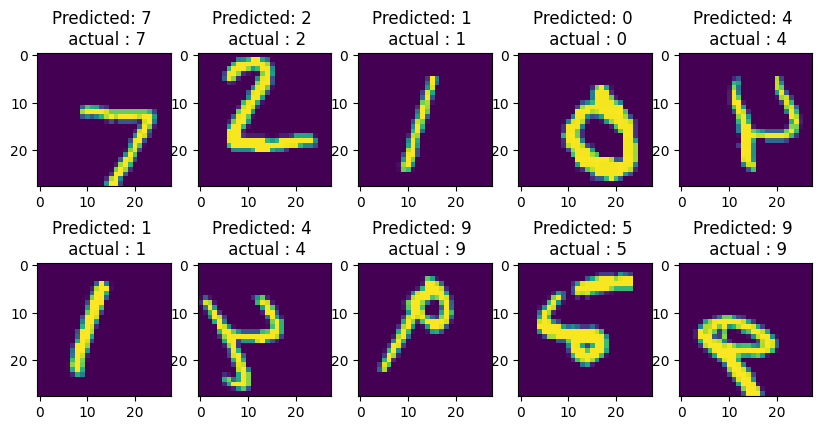

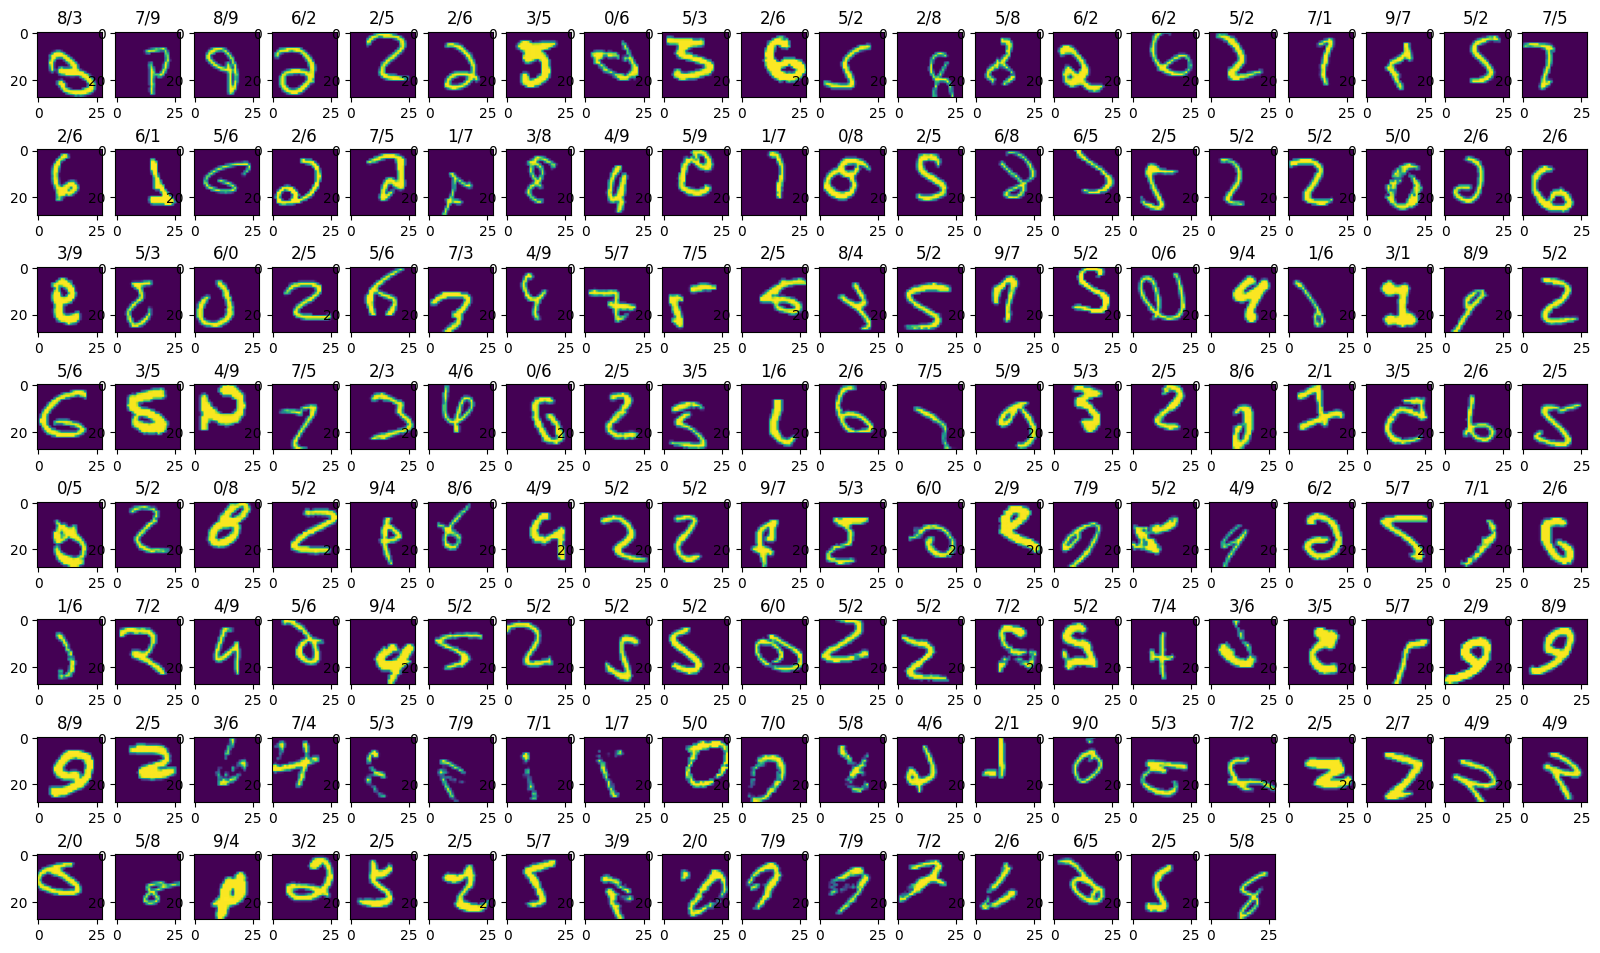

156


In [ ]:
model.load_state_dict(torch.load("MNIST.pth", map_location=device))

num_corr = 0

cor_sam = []
incor_sam = []
pred_list = []

with torch.no_grad():
  for data, label in test_loader:#데이터 로더 batchsize 32로 정해놓음
    
    output = model(data.to(device)) 
    #최대 index의 값을 preds에 저장
    preds = output.data.max(1)[1] #[32*10] 배치 단위에서 최대값을 찾음 max(1): 각각의 행에서 최댓값을 찾아 [32*1]로 저장. [0]:배치의 index, [1]:배치의 각각의 최댓값 
    pred_list += preds.tolist()

    #label에서 각 인덱스하고 값이 같은지를 비교해서 같으면 1 다르면 0 출력
    corr_mask = preds.eq(label.to(device).data) 
    corr = corr_mask.sum().item()
    
    num_corr += corr

    #원본 list(32, )
    cor_sam += [(data[i].to('cpu'), label.to(device).data[i]) for i in range(len(data))]
    incor_sam += [(data[i].to('cpu'), label.to(device).data[i]) for i in range(len(data)) if not corr_mask[i]]
print(f"Accuracy:{(num_corr/len(test_data)*100)}")

# Display all correctly classified samples
cnt = 0
plt.figure(figsize = (10,5))
for i, (sample,label) in enumerate(cor_sam):
  if pred_list[i] != label.item():
    continue
  if cnt >= 10:
    break
  plt.subplot(2, 5, cnt+1)
  plt.imshow(sample.permute(1, 2, 0))
  plt.title(f"Predicted: {pred_list[i]} \n actual : {label}")
  cnt += 1
plt.show()

print('\n',"=="*50,'\n')

# Display all incorrectly classified samples
cnt = 0
plt.figure(figsize = (20,15))
for i, (sample,label) in enumerate(cor_sam):
  if pred_list[i] == label.item():
    continue
  # if cnt >= 10:
  #   break
  plt.subplot(10,20, cnt+1)
  plt.imshow(sample.permute(1, 2, 0))
  plt.title(f"{pred_list[i]}/{label}")
  cnt += 1
plt.show()
print(len(incor_sam))

- 오탐 출력 이미지 위의 숫자/숫자의 의미는 (predict / actual)값을 나타냅니다.